# Vehicle Detection and Tracking

The goals / steps of this project are the following:

* Perform a Histogram of Oriented Gradients (HOG) feature extraction on a labeled training set of images and train a classifier Linear SVM classifier.
* Apply a color transform and append binned color features, as well as histograms of color, to HOG feature vector.
* Normalize features and randomize a selection for training and testing.
* Implement a sliding-window technique and use trained classifier to search for vehicles in images.
* Run pipeline on a video stream (start with the test_video.mp4 and later implement on full project_video.mp4) and create a heat map of recurring detections frame by frame to reject outliers and follow detected vehicles.
* Estimate a bounding box for vehicles detected.
---

## Loading Data

In [1]:
import glob

vehicle_images = glob.glob('./dataset/vehicles/**/*.png')
vehicles_count = len(vehicle_images)
print(vehicles_count)
non_vehicle_images = glob.glob('./dataset/non-vehicles/**/*.png')
non_vehicles_count = len(non_vehicle_images)
print(non_vehicles_count)

8792
8968


## Data Visualization

In [2]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_images(nrows, ncols, figsize, images, axis=False, axs_titles=[], title_fontsize=30, height_limit=None, width_limit=None, cmap=None):
    if height_limit != None:
        height = height_limit
    else:
        height = img.shape[0]
        
    if width_limit != None:
        width = width_limit
    else:
        width = img.shape[1]
    
    fig, axs = plt.subplots(nrows, ncols, figsize=figsize)
    fig.subplots_adjust(hspace = .2, wspace=.05)
    axs = axs.ravel()
    
    for i, image in enumerate(images):
        if not axis:
            axs[i].axis('off')
        
        if len(axs_titles) > 0:
            axs[i].set_title(axs_titles[i], fontsize=title_fontsize)
        
        axs[i].set_xlim([0,width])
        axs[i].set_ylim([height,0])
        
        axs[i].imshow(image, cmap=cmap)
    return axs

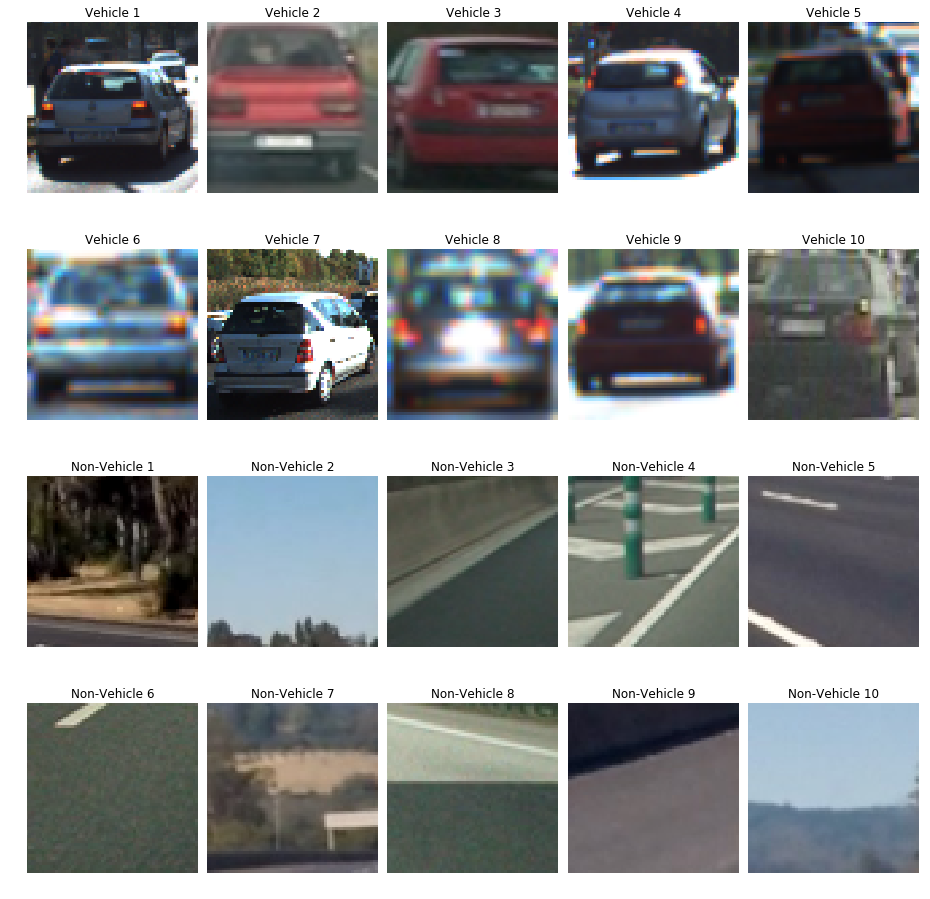

In [3]:
import numpy as np
import cv2

images = []
titles = []

for i in range(10):
    img = cv2.imread(vehicle_images[np.random.randint(0, vehicles_count)])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    images.append(img)
    titles.append('Vehicle ' + str(i+1))

for i in range(10):    
    img = cv2.imread(non_vehicle_images[np.random.randint(0, non_vehicles_count)])
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    
    images.append(img)
    titles.append('Non-Vehicle ' + str(i+1))

axs = plot_images(4, 5, (16, 16), images, axs_titles=titles, title_fontsize=12)

## Data Augmentation

In [4]:
def augment_brightness_camera_images(image):
    image1 = cv2.cvtColor(image,cv2.COLOR_RGB2HSV)
    random_bright = .25+np.random.uniform()
    #print(random_bright)
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv2.cvtColor(image1,cv2.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv2.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness

    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv2.getAffineTransform(pts1,pts2)

    img = cv2.warpAffine(img,Rot_M,(cols,rows))
    img = cv2.warpAffine(img,Trans_M,(cols,rows))
    img = cv2.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
      img = augment_brightness_camera_images(img)

    return img

In [5]:
import matplotlib.image as mpimg
new_vehicle_images = []
new_non_vehicle_images = []

for file in vehicle_images:
    image = mpimg.imread(file)
    new_vehicle_images.append(transform_image(image,10,5,5,brightness=1))
    
for file in non_vehicle_images:
    image = mpimg.imread(file)
    new_non_vehicle_images.append(transform_image(image,10,5,5,brightness=1))

## Image to Histogram of Oriented Gradients Conversion

In [6]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  block_norm= 'L2-Hys',
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       block_norm= 'L2-Hys',
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features


## HOG Visualization

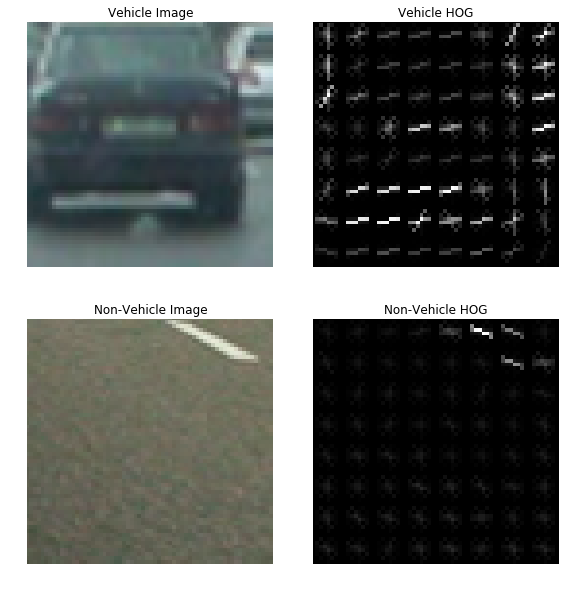

In [7]:
vehicle_img = mpimg.imread(vehicle_images[np.random.randint(0, vehicles_count)])
gray_vehicle_img = cv2.cvtColor(vehicle_img, cv2.COLOR_RGB2GRAY)
vehicle_features, vehicle_hog = get_hog_features(gray_vehicle_img, 9, 8, 8, vis=True, feature_vec=True)

non_vehicle_img = mpimg.imread(non_vehicle_images[np.random.randint(0, non_vehicles_count)])
gray_non_vehicle_img = cv2.cvtColor(non_vehicle_img, cv2.COLOR_RGB2GRAY)
non_vehicle_features, non_vehicle_hog = get_hog_features(gray_non_vehicle_img, 9, 8, 8, vis=True, feature_vec=True)

images = [vehicle_img, vehicle_hog, non_vehicle_img, non_vehicle_hog]
titles = ['Vehicle Image', 'Vehicle HOG', 'Non-Vehicle Image', 'Non-Vehicle HOG']

axs = plot_images(2, 2, (10, 10), images, axs_titles=titles, title_fontsize=12, cmap='gray')

## Combine Features and Training Classifier

In [8]:
def convert_to_cspace(img, cspace='RGB'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            out_img = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            out_img = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            out_img = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            out_img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            out_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: out_img = np.copy(img)
        
    return out_img        

def extract_features(imgs, augmented_imgs=False, cspace='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        if(not augmented_imgs):
            image = mpimg.imread(file)
            image = (image * 255).astype(np.uint8)
        else:
            image = file
            image = (image * 255).astype(np.uint8)
        # apply color conversion if other than 'RGB'
        feature_image = convert_to_cspace(image, cspace=cspace)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
  
        features.append(hog_features)
    # Return list of feature vectors
    return features

In [9]:
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.cross_validation import train_test_split

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t=time.time()
vehicle_features = extract_features(vehicle_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
non_vehicle_features = extract_features(non_vehicle_images, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
#augmented_vehicle_features = extract_features(new_vehicle_images, augmented_imgs=True, cspace=colorspace, orient=orient, 
#                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                        hog_channel=hog_channel)
#augmented_non_vehicle_features = extract_features(new_non_vehicle_images, augmented_imgs=True, cspace=colorspace, orient=orient, 
#                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
#                        hog_channel=hog_channel)

#vehicle_features += augmented_vehicle_features
#non_vehicle_features += augmented_non_vehicle_features

t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)
print(len(vehicle_features), len(non_vehicle_features))
# Define the labels vector
y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
    
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X_train)
# Apply the scaler to X
X_train = X_scaler.transform(X_train)
X_test = X_scaler.transform(X_test)

print('Using:',orient,'orientations',pix_per_cell, 'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

#parameters = {'kernel':('linear', 'rbf'), 'C':[1, 10]}
svc = svm.SVC(C=0.1)
#svc = GridSearchCV(svr, parameters)
t=time.time()
svc.fit(X_train, y_train)

# Use a linear SVC 
#svc = LinearSVC(C=0.01)

# Check the training time for the SVC
#t=time.time()
#svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

/home/guetteluis/miniconda3/envs/carnd-term1/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


97.9 Seconds to extract HOG features...
8792 8968
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188
111.91 Seconds to train SVC...
Test Accuracy of SVC =  0.9716
My SVC predicts:  [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.]
For these 10 labels:  [ 1.  1.  1.  1.  1.  1.  0.  0.  0.  1.]
0.13104 Seconds to predict 10 labels with SVC


## Find Vehicle in Image

In [10]:
def find_cars(img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, cspace='RGB'):
    coordinates = []
    #img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    ctrans_tosearch = convert_to_cspace(img_tosearch, cspace=cspace)  
    ctrans_tosearch = (ctrans_tosearch * 255).astype(np.uint8)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step + 1
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step + 1
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            #subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            #spatial_features = bin_spatial(subimg, size=(32, 32))
            #hist_features = color_hist(subimg, nbins=32)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack(hog_features).reshape(1, -1))   
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                coordinates.append((xleft,ytop)) 
            
    return coordinates, scale, ystart

def draw_rectangles(img, coordinates, scale, ystart):
    window = 64
    rectangles = []
    
    for coordinate in coordinates:
        xleft = coordinate[0]
        ytop = coordinate[1]
    
        xbox_left = np.int(xleft*scale)
        ytop_draw = np.int(ytop*scale)
        win_draw = np.int(window*scale)
        
        rectangle = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
        rectangles.append(rectangle)
        cv2.rectangle(img,rectangle[0], rectangle[1],(0,0,255),6)
    
    return img, rectangles

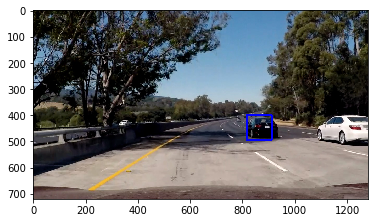

In [11]:
test_img = mpimg.imread('./test_images/test5.jpg')

ystart = 400
ystop = 500
scale = 1.5
    
coordinates, scale, ystart = find_cars(test_img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, colorspace)

draw_img = np.copy(test_img)
draw_img, rectangles = draw_rectangles(draw_img, coordinates, scale, ystart)

plt.imshow(draw_img)

## Testing with Different Sliding Window Ranges

In [12]:
def find_cars_more_windows(params, img, svc, orient, pix_per_cell, cell_per_block, colorspace):
    draw_img = np.copy(img)
    rectangles = []
    
    for param in params:
        ystart = param[0]
        ystop = param[1]
        scale = param[2]
        coordinates, scale, ystart = find_cars(img, ystart, ystop, scale, svc, orient, pix_per_cell, cell_per_block, colorspace)
        draw_img, partial_rectangles = draw_rectangles(draw_img, coordinates, scale, ystart)
        rectangles += partial_rectangles
    
    return draw_img, rectangles

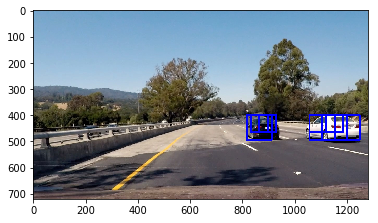

In [13]:
test_img = mpimg.imread('./test_images/test4.jpg')

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2

# (ystart, ystop, scale)
params = [
    (400, 464, 1),
    (400, 500, 1.5),
]

draw_img, rectangles = find_cars_more_windows(params, test_img, svc, orient, pix_per_cell, cell_per_block, colorspace)
    
plt.imshow(draw_img)

## Applying Headmap

In [14]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

def apply_heatmap(draw_img, rectangles):
    heat = np.zeros_like(draw_img[:,:,0])

    # Add heat to each box in box list
    heat = add_heat(heat, rectangles)

    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,2)

    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)

    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(draw_img), labels)
    
    return heatmap, labels

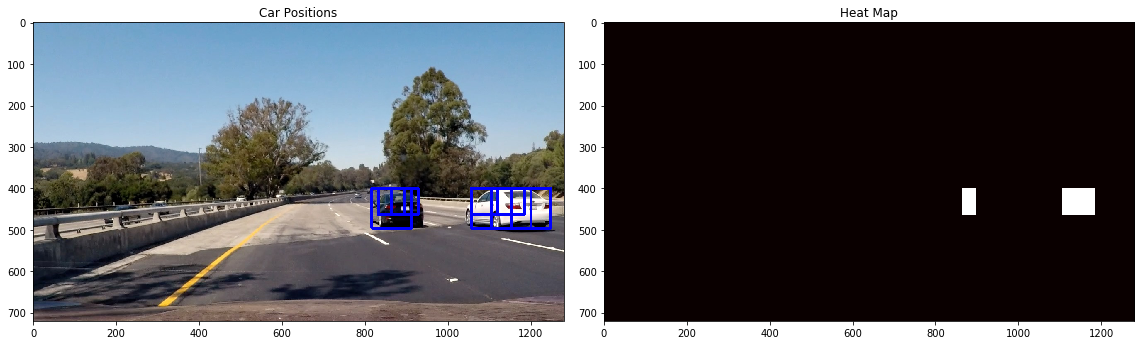

In [15]:
from scipy.ndimage.measurements import label

heatmap, labels = apply_heatmap(draw_img, rectangles)

fig = plt.figure(figsize=(16,16))
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Drawing Labeled Bounding Boxes

In [16]:
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

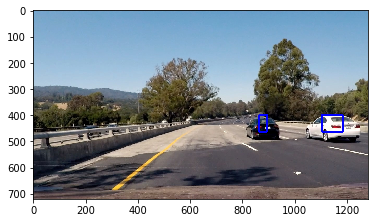

In [17]:
# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
# Display the image
plt.imshow(draw_img)

## Testing with Test Images

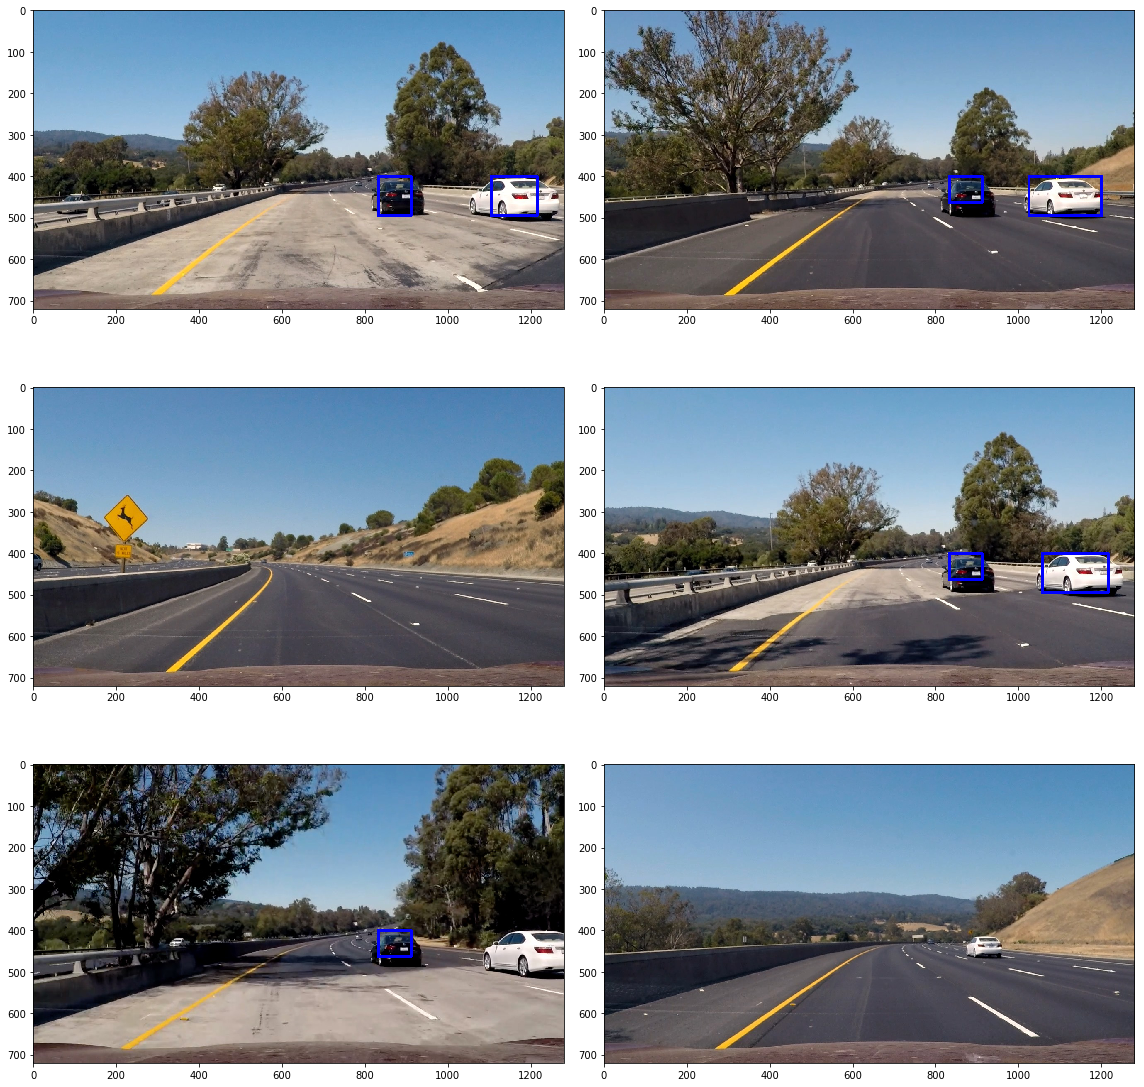

In [18]:
test_images = glob.glob('./test_images/*.jpg')

colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2

# (ystart, ystop, scale)
params = [
    (400, 464, 1),
    (400, 496, 1.5),
    (400, 530, 2),
]
    

draw_images = []

for test_img in test_images:
    test_img = mpimg.imread(test_img)

    draw_img, rectangles = find_cars_more_windows(params, test_img, svc, orient, pix_per_cell, cell_per_block, colorspace)
    
    heatmap, labels = apply_heatmap(draw_img, rectangles)
    
    draw_img = draw_labeled_bboxes(np.copy(test_img), labels)
    
    draw_images.append(draw_img)    

fig = plt.figure(figsize=(16,16))
plt.subplot(321)
plt.imshow(draw_images[0])
plt.subplot(322)
plt.imshow(draw_images[1])
plt.subplot(323)
plt.imshow(draw_images[2])
plt.subplot(324)
plt.imshow(draw_images[3])
plt.subplot(325)
plt.imshow(draw_images[4])
plt.subplot(326)
plt.imshow(draw_images[5])
fig.tight_layout()

## Defining pipeline

In [33]:
from collections import deque

class Detections():
    def __init__(self):
        self.rectangles = deque(maxlen = 12) 
        
    def add_new_rectangles(self, new_rectangles):
        self.rectangles += new_rectangles
        
        #if len(self.rectangles) > 20:
        #   self.rectangles = self.rectangles[len(self.rectangles)-20:]

def detect_vehicles(img):
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2

    # (ystart, ystop, scale)
    params = [
        (420, 516, 1.5),
    ]
    
    draw_img, rectangles = find_cars_more_windows(params, img, svc, orient, pix_per_cell, cell_per_block, colorspace)
    
    if len(rectangles) > 0:
        detections.add_new_rectangles(rectangles)
    
    heatmap, labels = apply_heatmap(draw_img, detections.rectangles)
    
    draw_img = draw_labeled_bboxes(np.copy(img), labels)

    return draw_img

## Test Pipeline in videos

In [35]:
from moviepy.editor import VideoFileClip

detections = Detections()

test_out_file = 'test_video_out.mp4'
clip_test = VideoFileClip('test_video.mp4')
clip_test_out = clip_test.fl_image(detect_vehicles)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video test_video_out.mp4
[MoviePy] Writing video test_video_out.mp4



 97%|█████████▋| 38/39 [00:16<00:00,  2.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_out.mp4 

CPU times: user 17.8 s, sys: 200 ms, total: 18 s
Wall time: 18.4 s


In [36]:
from moviepy.editor import VideoFileClip

detections = Detections()

test_out_file = 'project_video_out.mp4'
clip_test = VideoFileClip('project_video.mp4')
clip_test_out = clip_test.fl_image(detect_vehicles)
%time clip_test_out.write_videofile(test_out_file, audio=False)

[MoviePy] >>>> Building video project_video_out.mp4
[MoviePy] Writing video project_video_out.mp4



 12%|█▏        | 152/1261 [01:12<08:50,  2.09it/s]


 24%|██▍       | 303/1261 [02:23<07:33,  2.11it/s]


 36%|███▌      | 454/1261 [03:35<06:23,  2.11it/s]


 48%|████▊     | 605/1261 [04:45<05:09,  2.12it/s]


 60%|█████▉    | 756/1261 [05:57<03:58,  2.12it/s]


 72%|███████▏  | 907/1261 [07:04<02:45,  2.14it/s]


 84%|████████▍ | 1057/1261 [08:11<01:34,  2.15it/s]


 96%|█████████▌| 1205/1261 [09:17<00:25,  2.16it/s]


100%|█████████▉| 1260/1261 [09:41<00:00,  2.17it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_out.mp4 

CPU times: user 10min 11s, sys: 4.89 s, total: 10min 16s
Wall time: 9min 43s
